In [1]:
import pandas as pd
import numpy as np
import dill as pickle

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
cur_path = r"C:\Users\janni\OneDrive\TU Berlin\4 - Abschlussarbeiten\01 - Bachelorarbeit\modell\data\\"

In [3]:
period = pd.date_range('2017-01-21 00:00', '2017-01-28 23:45', freq='h')

In [4]:
excelFile_dispatch_real = pd.ExcelFile(cur_path + "DE Realisierte Erzeugung 2017.xlsx")
excelFile_demand = pd.ExcelFile(cur_path + 'DE Realisierter Stromverbrauch 2017.xlsx')

In [5]:
df_dispatch_ee_real = pd.read_excel(excelFile_dispatch_real,sheet_name="Realisierte Erzeugung",
                                 index_col=0, header=0, usecols="A,B,C,D,E,F,G,L")
df_dispatch_fossil_real = pd.read_excel(excelFile_dispatch_real,sheet_name="Realisierte Erzeugung",
                                 index_col=0, header=0, usecols="A,H,I,J,K")

df_demand = pd.read_excel(excelFile_demand, sheet_name="mapping_demand",
                          index_col=0, header=0, usecols="A:J")

In [6]:
with open('network.pickle', 'rb') as f:
    network = pickle.load(f)

In [7]:
s_dispatch_ee_real = (df_dispatch_ee_real.replace('-',0)
                        .resample('1H').sum()
                        .agg('sum', axis='columns')
                        .loc[period])
df_dispatch_fossil_real = (df_dispatch_fossil_real.replace('-',0)
                           .resample('1H').apply(np.sum)
                           .loc[period])

df_demand = (df_demand.replace('-',0)
             .resample('1H').sum()
             .agg('sum', axis='columns')
             .loc[period])

In [8]:
df_dispatch_real = df_dispatch_fossil_real
df_dispatch_real['ee'] = s_dispatch_ee_real
df_dispatch_real.rename(columns={
    "Kernenergie[MWh]":"Kernenergie",
    "Braunkohle[MWh]":"Braunkohle",
    "Steinkohle[MWh]":"Steinkohle",
    "Erdgas[MWh]":"Erdgas",
}, inplace=True)
# df_dispatch_real.head(3)

In [29]:
colors = {"Erdgas":"orange",
          "Braunkohle":"brown",
          "Steinkohle":"black",
          "Wind":"blue",
          "ee":"green",
          "Import":"red",
          "Kernenergie":"yellow"}

In [32]:
df_dispatch_real = df_dispatch_real[["Kernenergie", "ee", "Braunkohle", "Steinkohle", "Erdgas"]]

In [31]:
df_dispatch_calculated = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()
df_dispatch_calculated[df_dispatch_calculated < 0] = 0
df_dispatch_calculated = df_dispatch_calculated[["Wind", "ee", "Braunkohle", "Steinkohle", "Erdgas", "Import"]]
# df_dispatch_calculated()

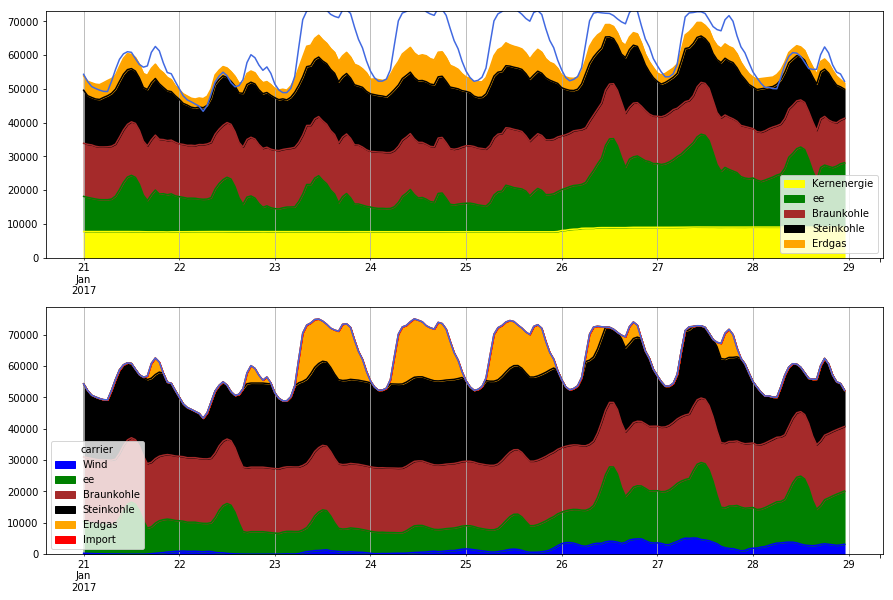

In [37]:
fig,(ax1, ax2) = plt.subplots(2,1)
fig.set_size_inches(15,10)

ax1.grid(True, which='minor')
df_dispatch_real.plot(kind='area', ax=ax1, grid=True, color=[colors[i] for i in df_dispatch_real.columns])
df_demand.plot(ax=ax1, color='royalblue')

ax2.grid(True, which='minor')
df_dispatch_calculated.plot(kind='area', ax=ax2, color=[colors[i] for i in df_dispatch_calculated.columns])
df_demand.plot(ax=ax2, color='royalblue')

Calculate the difference for each snap for each carrier

In [60]:
df_dispatch_difference = pd.DataFrame(columns=colors.keys())

for key in colors.keys():
    if key in df_dispatch_real.columns and key in df_dispatch_calculated.columns:
#         print(type(key))
        df_dispatch_difference[key] = (df_dispatch_calculated[key] - df_dispatch_real[key])
    else:
        df_dispatch_difference[key] = 0

In [67]:
df_dispatch_difference = df_dispatch_difference[["Kernenergie", "ee", "Braunkohle", "Steinkohle", "Erdgas", "Import"]]

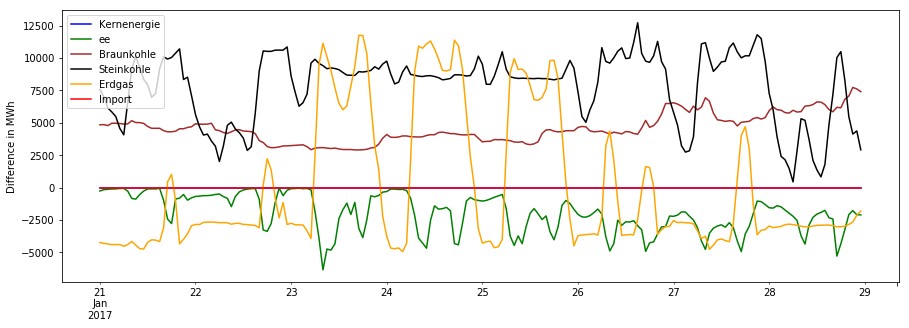

In [68]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(15,5)

ax.grid(True)
ax.set_ylabel("Difference in MWh")
df_dispatch_difference.plot(ax=ax, color=[colors[i] for i in df_dispatch_calculated.columns])